In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


# Data Wrangling of one file tracking data

The dataset contains 5min of tracking information for each player in a club, recording their precise x and y coordinates.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import seaborn as sns
import glob
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from scipy.stats import multivariate_normal
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans
import warnings
import networkx as nx
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Load tracking data from one recording of 5 minutes

In [3]:
data = pd.read_csv("tracking_data.txt", sep=",", header=None)
data.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
data.head()

frame_number  track_id  role    xbox   ybox     w     h  xworld  yworld  \
0             0        61     0  1596.2  265.0  62.1  97.6    47.6    48.1   
1             0        62     1  1646.2  146.1  31.3  58.7    47.8    31.9   
2             0        63     0  1590.5  165.0  28.6  61.5    46.3    35.2   
3             0        64     3   855.9  292.0  34.5  51.7    19.3    33.5   
4             0        65     1  1770.2   95.4  19.4  38.7    52.4    13.6   

    IoU  
0  0.00  
1  0.00  
2  0.00  
3  0.00  
4  0.05

`role` feature:
* 0/1 - players
* 2 - ref
* 3/4 - goalies
* -1 - unused detections (non-players and non-refs)
  

`xworld` and `yworld` are in meters measured from the back left corner flag (from the point of view of the camera).

In [4]:
data.shape

(28565, 10)

In [5]:
data["track_id"].nunique()

30

We have 30 unique tracking IDs, representing only the outfield players and referees.

As a result, there may be instances where non-player or non-referee objects are detected, or cases where an object is reassigned or re-identified. This can happen in highly occluded situations (in football these are corners or free kicks, with a large number of players on a small area of the pitch)

In [6]:
data["role"].value_counts()

 0    12469
 1    12455
 2     1250
 4     1250
 3     1134
-1        7
Name: role, dtype: int64

In [16]:
data

frame_number  track_id  role  xworld  yworld   IoU
0                 0        61     0    47.6    48.1  0.00
1                 0        62     1    47.8    31.9  0.00
2                 0        63     0    46.3    35.2  0.00
3                 0        64     3    19.3    33.5  0.00
4                 0        65     1    52.4    13.6  0.05
...             ...       ...   ...     ...     ...   ...
28560          7494        74     0    80.5    51.1  0.00
28561          7494        81     0    63.9    35.6  0.00
28562          7494        77     1    74.4    30.1  0.20
28563          7494        71     1    63.0    65.7  0.36
28564          7494        68     2    63.1    65.2  0.36

[28565 rows x 6 columns]

remove the unnecessary columns

In [8]:
data = data.drop( ["xbox", "ybox", "w", "h"], axis=1)

In [17]:
def normalize_tracking_data(df):
    df[['xworld_norm', 'yworld_norm']] = df.groupby('frame_number')[['xworld', 'yworld']].transform(
        lambda x: x - x.mean()
    )
    return df

In [18]:
normalize_tracking_data(data)

frame_number  track_id  role  xworld  yworld   IoU  xworld_norm  \
0                 0        61     0    47.6    48.1  0.00   -18.213333   
1                 0        62     1    47.8    31.9  0.00   -18.013333   
2                 0        63     0    46.3    35.2  0.00   -19.513333   
3                 0        64     3    19.3    33.5  0.00   -46.513333   
4                 0        65     1    52.4    13.6  0.05   -13.413333   
...             ...       ...   ...     ...     ...   ...          ...   
28560          7494        74     0    80.5    51.1  0.00    17.418182   
28561          7494        81     0    63.9    35.6  0.00     0.818182   
28562          7494        77     1    74.4    30.1  0.20    11.318182   
28563          7494        71     1    63.0    65.7  0.36    -0.081818   
28564          7494        68     2    63.1    65.2  0.36     0.018182   

       yworld_norm  
0        18.680000  
1         2.480000  
2         5.780000  
3         4.080000  
4       -15.820000  
...            ...  
28560     0.718182  
28561   -14.781818  
28562   -20.281818  
28563    15.318182  
28564    14.818182  

[28565 rows x 8 columns]

first frame of the clip of team 0 
also set the zeropoint to lowerleft be minimizing by 68

In [ ]:
data[(data["frame_number"] == 0) & (data["role"] == 0)]
data["yworld"] = 68 - data["yworld"]
data.head(10)

frame_number  track_id  role  xworld  yworld   IoU
0             0        61     0    47.6    19.9  0.00
1             0        62     1    47.8    36.1  0.00
2             0        63     0    46.3    32.8  0.00
3             0        64     3    19.3    34.5  0.00
4             0        65     1    52.4    54.4  0.05
5             0        66    -1    52.6    66.6  0.05
6             0        67    -1    31.2    67.7  0.00
7             0        68     2    63.1    23.1  0.00
8             0        69     0    55.6    31.2  0.01
9             0        70     1    73.6    34.7  0.09

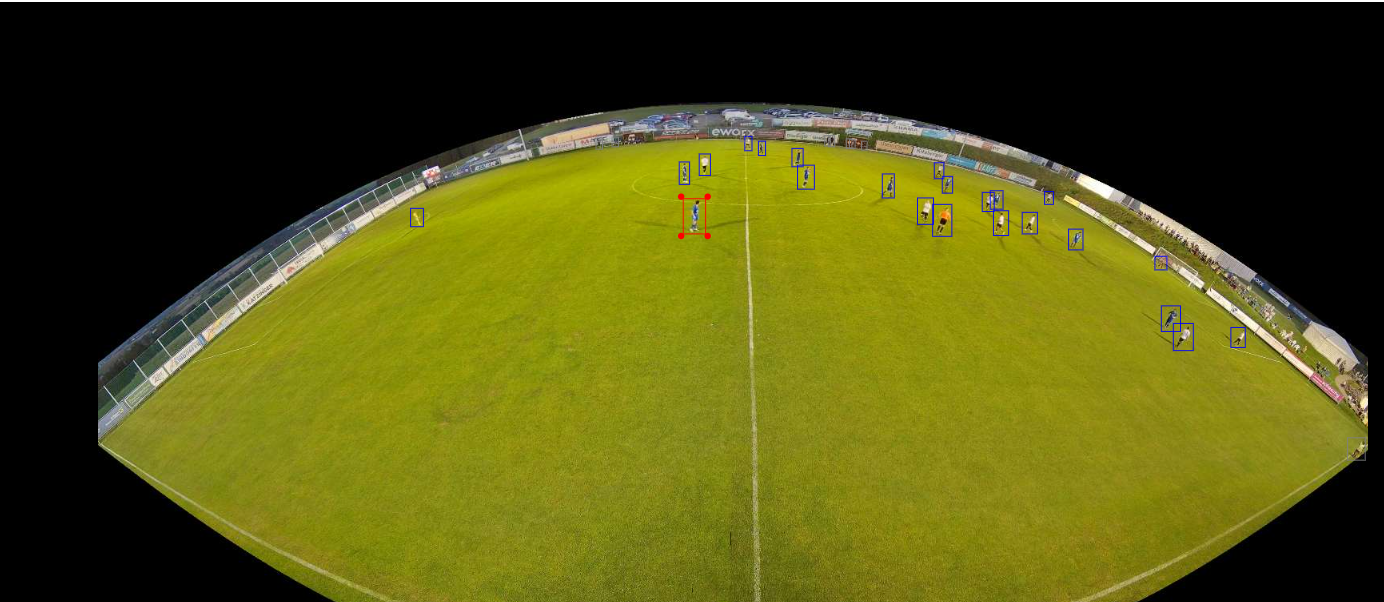

# EDA

In [ ]:
data_team0 = data[data["role"] == 0]
data_team0["track_id"].nunique()   

10

plot the first 5min of tracking/runnning data from each player

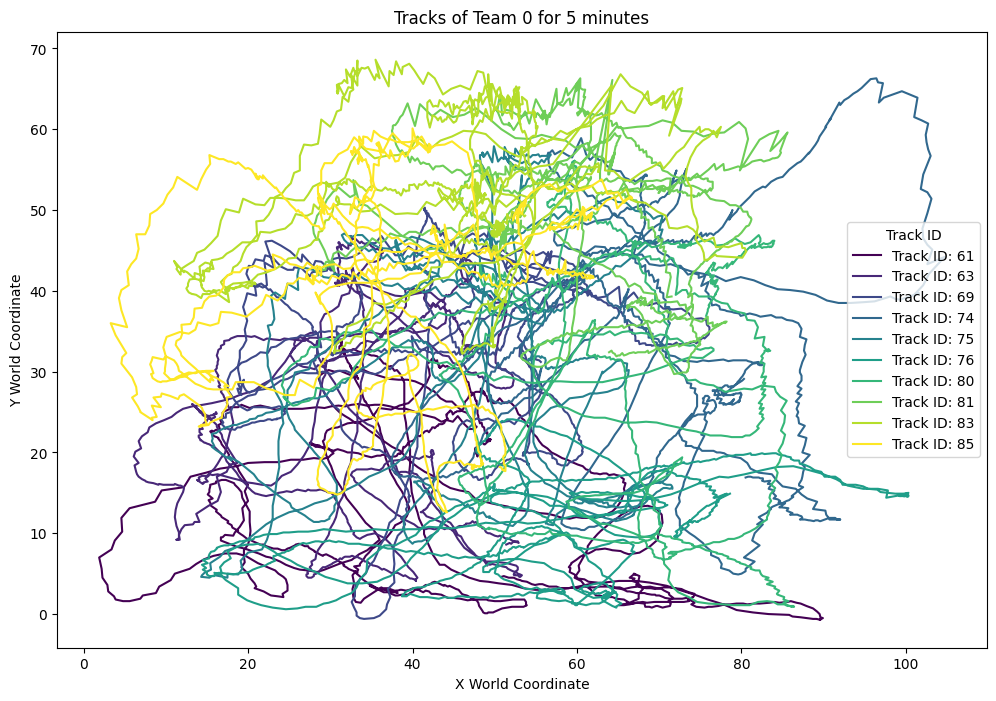

In [ ]:
# Get unique track IDs
unique_tracks = data_team0['track_id'].unique()

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_tracks)))
for idx, track_id in enumerate(unique_tracks):
    track_data = data_team0[data_team0['track_id'] == track_id]
    plt.plot(track_data['xworld'], track_data['yworld'], color=colors[idx], linestyle='-', markersize=1, label=f'Track ID: {track_id}')

plt.title('Tracks of Team 0 for 5 minutes')
plt.xlabel('X World Coordinate')
plt.ylabel('Y World Coordinate')
plt.legend(title='Track ID')
plt.show()

In [ ]:
data[(data["frame_number"] >= 0) & (data["track_id"] == 61)]

frame_number  track_id  role  xworld  yworld  IoU
0                 0        61     0    47.6    19.9  0.0
30                6        61     0    47.8    19.9  0.0
53               12        61     0    47.9    19.5  0.0
76               18        61     0    47.9    19.5  0.0
99               24        61     0    47.9    19.5  0.0
...             ...       ...   ...     ...     ...  ...
28466          7470        61     0    52.3     4.5  0.0
28488          7476        61     0    51.9     4.5  0.0
28510          7482        61     0    51.7     4.5  0.0
28532          7488        61     0    51.1     4.7  0.0
28554          7494        61     0    50.8     4.6  0.0

[1241 rows x 6 columns]

have a look into the tracking data of player with `track_id` 61

In [ ]:
player_61 = data[(data["track_id"] == 61) & (data["role"] == 0)]
player_61_xy = pd.DataFrame({'x': player_61["xworld"], 'y': player_61["yworld"]})

function to create football image

In [ ]:
def create_pitch(df):
 
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.set_facecolor('green')
    plt.plot([0, 0, 105, 105, 0], [0, 68, 68, 0, 0], color="white")
    plt.plot([16.5, 16.5, 0, 0, 16.5], [21.16, 46.84, 46.84, 21.16, 21.16], color="white")
    plt.plot([105, 105 - 16.5, 105 - 16.5, 105, 105], [21.16, 21.16, 46.84, 46.84, 21.16], color="white")
    plt.plot([0, 6, 6, 0], [30.9, 30.9, 37.1, 37.1], color="white")
    plt.plot([105, 105 - 6, 105 - 6, 105], [30.9, 30.9, 37.1, 37.1], color="white")

    center_circle = plt.Circle((52.5, 34), 9.15, color="white", fill=False)
    ax.add_patch(center_circle)

    plt.plot([52.5, 52.5], [0, 68], color="white")
    plt.plot(11, 34, 'wo')  
    plt.plot(94, 34, 'wo')  
    plt.plot(52.5, 34, 'wo')  
    plt.plot([0, 0], [30.9, 37.1], color="white", linewidth=8)  
    plt.plot([105, 105], [30.9, 37.1], color="white", linewidth=8)  

    ax.set_xlim(-5, 110)
    ax.set_ylim(-5, 73)
    ax.set_aspect('equal')
   
    plt.xticks([])
    plt.yticks([])
    
    plt.title('Player tracking - 5min', fontsize=20)
    
    sns.kdeplot(x=df['x'], y=df['y'], ax=ax, shade=True, cmap="coolwarm", n_levels=30, alpha=0.7, label='Movement Density')
    plt.plot(df['x'], df['y'], color='blue', linestyle='-', marker='o', markersize=3, label='Player Runline')
    plt.scatter(df['x'].iloc[0], df['y'].iloc[0], color='green', s=100, label='Start Point', edgecolor='black')
    plt.scatter(df['x'].iloc[-1], df['y'].iloc[-1], color='red', s=100, label='End Point', edgecolor='black')

    plt.legend()
    plt.grid(False)
    plt.show()

plot the first 5min of tracking data of player with `player_id` 61 with lineplot and heatmap

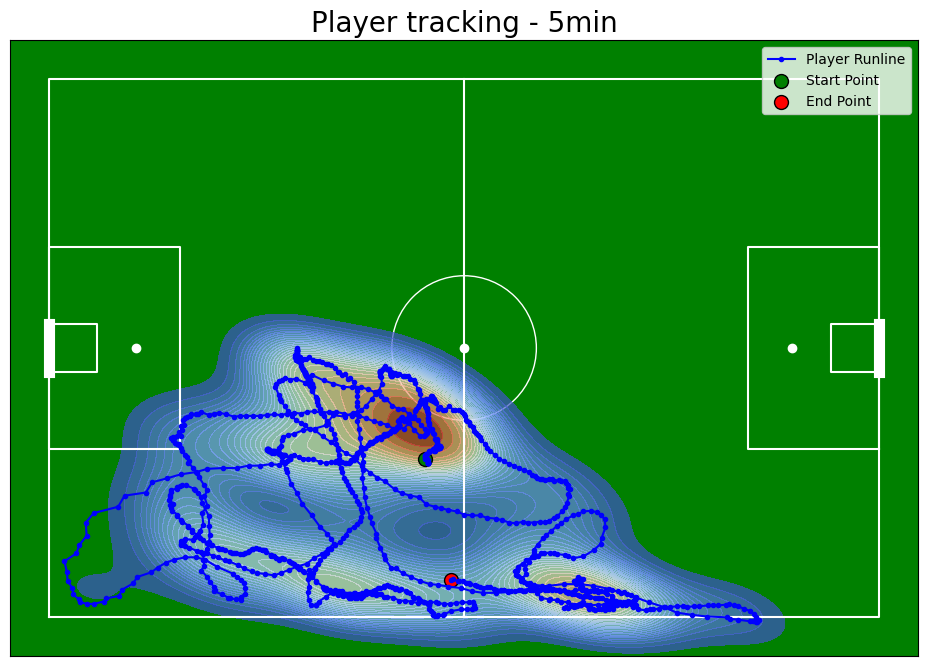

In [ ]:
create_pitch(player_61_xy)

Add convex hull of player 61

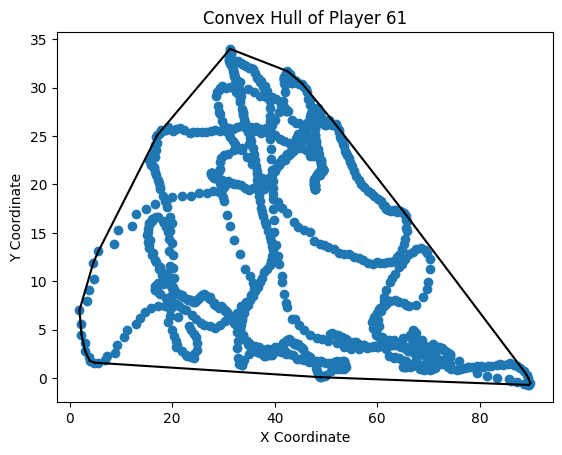

In [ ]:
points = player_61_xy[['x', 'y']].values
hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Convex Hull of Player 61')
plt.show()

Now we save the tracking data of team 0 in the variable `players_role_0`

In [ ]:
players_role_0 = data[data["role"] == 0]
players_role_0.head(10)

frame_number  track_id  role  xworld  yworld   IoU
0              0        61     0    47.6    19.9  0.00
2              0        63     0    46.3    32.8  0.00
8              0        69     0    55.6    31.2  0.01
13             0        74     0    80.3    29.1  0.00
14             0        75     0    62.4    31.6  0.00
15             0        76     0    78.6    14.9  0.00
19             0        80     0    75.7    36.9  0.09
20             0        81     0    71.5    39.3  0.00
22             0        83     0    53.7    49.3  0.00
24             0        85     0    56.8    42.2  0.01

draw all convex hulls from each player of team 0, which gives us a raw assumptions what role/formation they play

/var/folders/6t/2kykm1l51vv3mrsbvhz5jznc0000gn/T/ipykernel_92060/1764362565.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab20", len(players_role_0['track_id'].unique()))
/var/folders/6t/2kykm1l51vv3mrsbvhz5jznc0000gn/T/ipykernel_92060/1764362565.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best", title="Players")


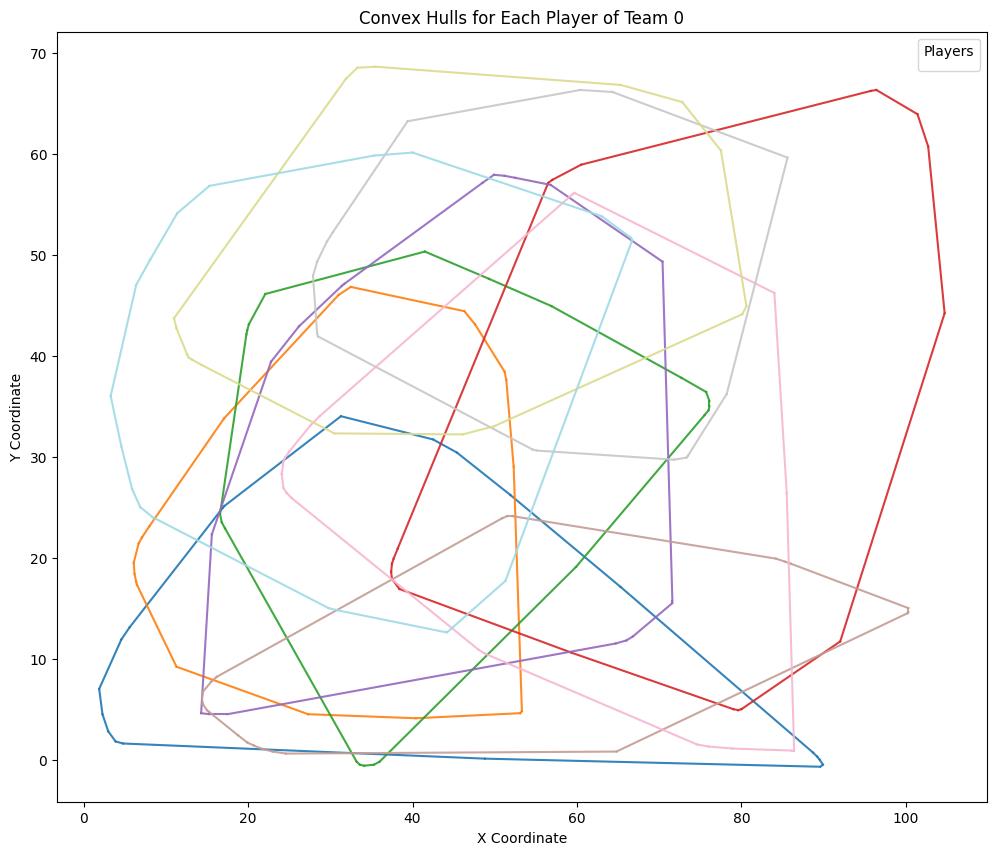

In [ ]:
plt.figure(figsize=(12, 10))
color_map = cm.get_cmap("tab20", len(players_role_0['track_id'].unique()))

for i, player_id in enumerate(players_role_0['track_id'].unique()):
    player_data = players_role_0[players_role_0['track_id'] == player_id]
    points = player_data[['xworld', 'yworld']].values  
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], '-', color=color_map(i), alpha=0.9)
    
plt.title('Convex Hulls for Each Player of Team 0')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(loc="best", title="Players")
plt.show()


# Role discovery using minimum entropy data partitions
according to Alina Bialkowski, Patrick Lucey et al. 2014. Large-scale analysis of soccer matches using spatiotemporal
tracking data. In IEEE International Conference on Data Mining

To identify specific role clusters for each player, we process the tracking data using K-Means clustering and the Hungarian algorithm (linear sum assignment). The process begins by normalizing player positions and initializing roles with K-Means clustering. Subsequently, roles are iteratively refined by minimizing a cost matrix derived from Gaussian probability distributions for each role. As the roles converge, Gaussian parameters are updated to improve accuracy. The process is complemented by visualizations that depict the progression and final structure of the role clusters.

## Normalize the tracking data

In [ ]:
def normalize_tracking_data(df):
    df[['xworld_norm', 'yworld_norm']] = df.groupby('frame_number')[['xworld', 'yworld']].transform(
        lambda x: x - x.mean()
    )
    return df

## Assign initial specialized roles using K-Means

In [ ]:
def initialize_roles_with_kmeans(df, n_roles): 
    kmeans = KMeans(n_clusters=len(n_roles), init='k-means++', random_state=42)
    normalized_positions = df[['xworld_norm', 'yworld_norm']].values
    df['specialized_role'] = kmeans.fit_predict(normalized_positions)
    initial_means = kmeans.cluster_centers_

    #track_ids = df['track_id'].unique()
    
    # Map cluster labels to track IDs
    #cluster_to_track_id = {i: track_id for i, track_id in enumerate(track_ids)}
    #df['specialized_role'] = df['specialized_role'].map(cluster_to_track_id)
    
    # Define specific names for the clusters
    cluster_names = {
        61: 'RV',
        63: 'RIV',
        69: 'ZM',
        74: 'ST',
        75: 'ZOM',
        76: 'RM',
        80: 'LST',
        81: 'LM',
        83: 'LV',
        85: 'LIV'
    }
    
    # Map the specialized roles to the specific names
    df['role_name'] = df['track_id'].map(cluster_names)

    return df, initial_means
   

## Set initial positions and roles

In [ ]:
players_role_0 = normalize_tracking_data(players_role_0)
n_roles = np.unique(players_role_0['track_id'])
players_role_0, initial_means = initialize_roles_with_kmeans(players_role_0, n_roles)
players_role_0.head(10)


frame_number  track_id  role  xworld  yworld   IoU  xworld_norm  \
0              0        61     0    47.6    19.9  0.00       -15.25   
2              0        63     0    46.3    32.8  0.00       -16.55   
8              0        69     0    55.6    31.2  0.01        -7.25   
13             0        74     0    80.3    29.1  0.00        17.45   
14             0        75     0    62.4    31.6  0.00        -0.45   
15             0        76     0    78.6    14.9  0.00        15.75   
19             0        80     0    75.7    36.9  0.09        12.85   
20             0        81     0    71.5    39.3  0.00         8.65   
22             0        83     0    53.7    49.3  0.00        -9.15   
24             0        85     0    56.8    42.2  0.01        -6.05   

    yworld_norm  specialized_role role_name  
0        -12.82                 9        RV  
2          0.08                 1       RIV  
8         -1.52                 8        ZM  
13        -3.62                 2        ST  
14        -1.12                 0       ZOM  
15       -17.82                 4        RM  
19         4.18                 7       LST  
20         6.58                 0        LM  
22        16.58                 3        LV  
24         9.48                 5       LIV

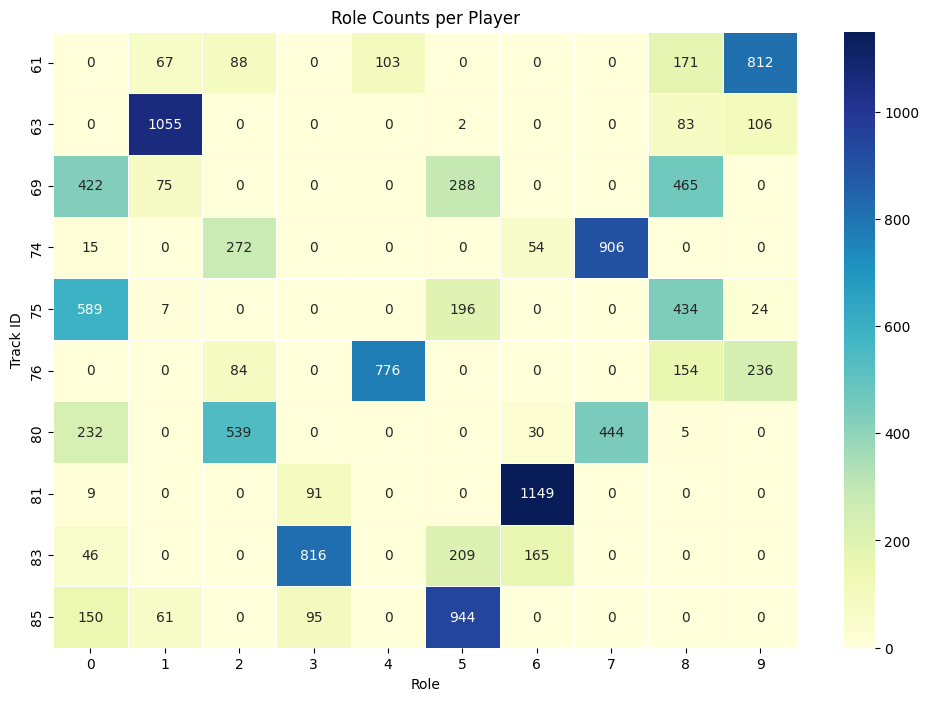

In [ ]:
players_role_0.groupby('track_id')['specialized_role'].unique()
role_counts_per_player = players_role_0.groupby('track_id')['specialized_role'].value_counts()
#print(role_counts_per_player)
role_counts_df = role_counts_per_player.unstack().fillna(0).astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(role_counts_df, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5)
plt.title('Role Counts per Player')
plt.xlabel('Role')
plt.ylabel('Track ID')
plt.show()

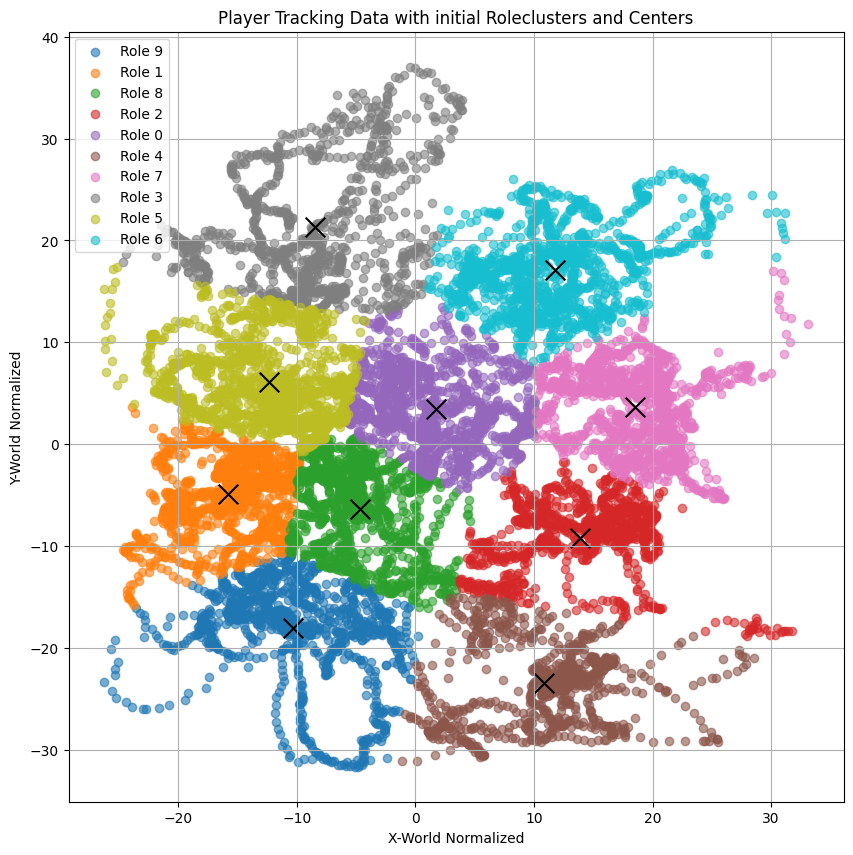

In [ ]:
# Visualize final results

def plot_tracking_data(df, centers,  title:str, col:str=None,):
    fig, ax = plt.subplots(figsize=(10, 10))
    roles = df['specialized_role'].unique()
    colors = [plt.cm.tab10(i % 10) for i in range(len(roles))]
    
    for role in roles:
        role_data = df[df[col] == role]
        ax.scatter(role_data['xworld_norm'], role_data['yworld_norm'], label=f'Role {role}', alpha=0.6)
    
    # Plot the centers as black X
    if centers is not None:
        for center in centers:
            ax.scatter(center[0], center[1], color='black', marker='x', s=200)
    
    ax.set_title(title)
    ax.set_xlabel('X-World Normalized')
    ax.set_ylabel('Y-World Normalized')
    ax.legend()
    ax.grid()
    plt.show()
plot_tracking_data(players_role_0, initial_means, col="specialized_role", title="Player Tracking Data with initial Roleclusters and Centers")


## Create a cost matrix and use Hungarian algorithm
Compute cost matrix based on log probabilities with separation bias

In [ ]:
# PDF's stands for Probability Density Functions --> zu deutsch "Wahrscheinlichkeitsdichtefunktion"
def compute_cost_matrix(positions, role_pdfs, separation_bias=1.0): # separation_bias is a hyperparameter which influences the cost matrix, a higher value means a higher cost for players being close to each other
    n_positions = len(positions) # len of outer array, bc input is a 2D array
    n_roles = len(role_pdfs)
    cost_matrix = np.zeros((n_positions, n_roles)) # build the raw cost matrix

    for i, pos in enumerate(positions):
        for j, pdf in enumerate(role_pdfs):
            # Negative log-probability for cost, with a small separation bias
            cost_matrix[i, j] = -np.log(pdf.pdf(pos) + 1e-8) + separation_bias * np.sum(np.abs(pos - pdf.mean)) 
            # Manhattan distance
            # np.linalg.norm would be the euclidean distance
            # The cost is calculated as the negative log-probability of the position given the role, + a  bias term that encourages players to be spread out
            # it pemalizes points/players with low probability of being in a certain role and add the distance between the point and the role mean

    return cost_matrix


### Example of how the role switch occurs by calculating the cost matrix and linear assignment 

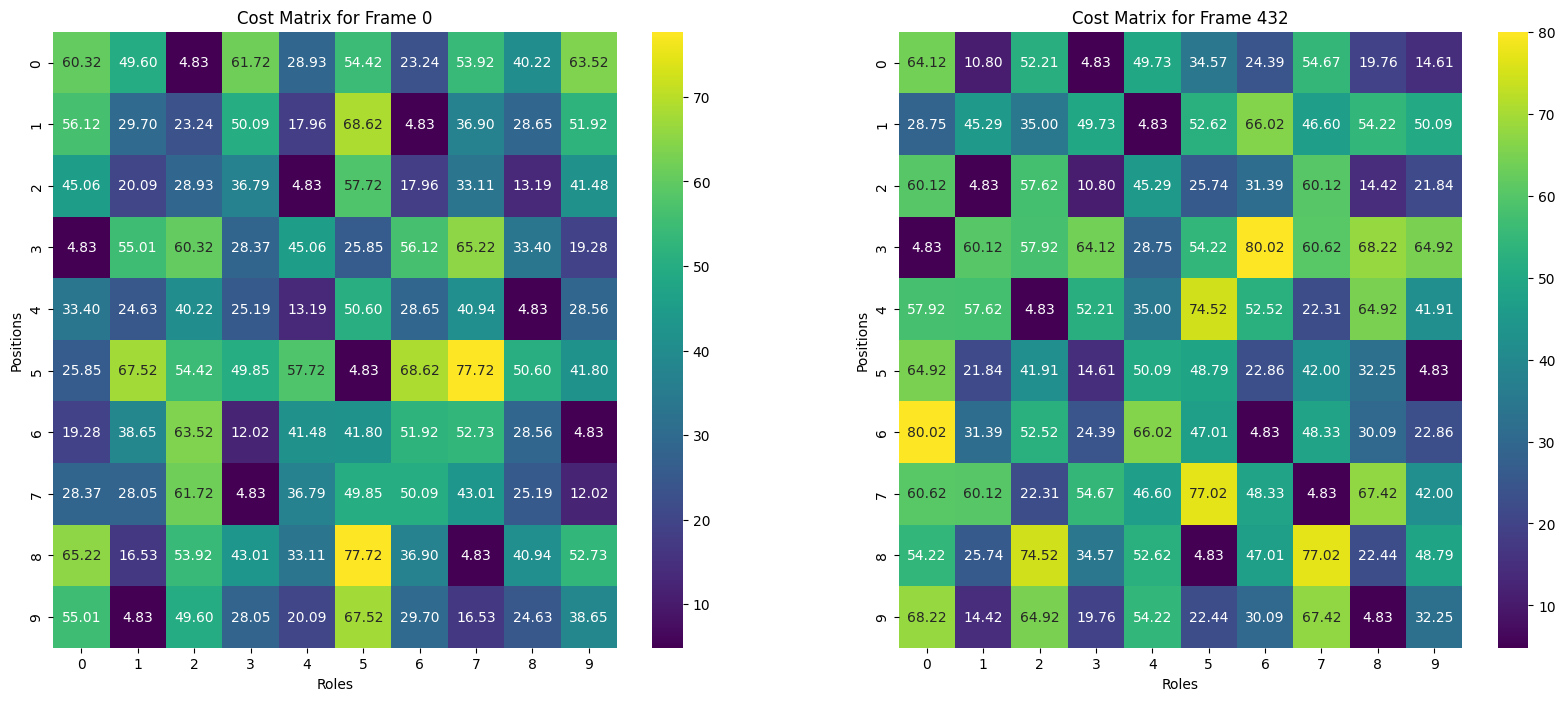

In [ ]:
example_df_0 = players_role_0[players_role_0['frame_number'] == 0] # get the data for frame 0 of team 0
example_df_0 = normalize_tracking_data(example_df_0) # normalize the data
n_roles = example_df_0['track_id'].unique() # get the unique track ids, e.g. [61, 63, 69, 74, 75, 76, 80, 81, 83, 85]
dd_0, initial_means_0 = initialize_roles_with_kmeans(example_df_0, n_roles) # initialize the roles with kmeans
positions_0 = dd_0[['xworld_norm', 'yworld_norm']].values # get the normalized positions after kmeans
unique_roles_0 = np.unique(dd_0['specialized_role']) # get the unique roles after kmeans [0,1,2,3,4,5,6,7,8,9]

role_to_index = {role: idx for idx, role in enumerate(unique_roles_0)} # create a dictionary with the role as key and the index as value, like {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}

# create a dictionary with the role as key and the multivariate normal distribution as value
# each role has a multivariate normal distribution with the mean of the initial means and a covariance matrix of the identity matrix * 20
role_pdfs_0 = {
    role: multivariate_normal(
        mean=initial_means_0[role_to_index[role]], cov=np.eye(2) * 20 # np.eye(2) is the identity matrix with 2 dimensions; array([[20.,  0.], [ 0., 20.]])
    ) for role in unique_roles_0
}

cost_matrix_0 = compute_cost_matrix(positions_0, [role_pdfs_0[role] for role in unique_roles_0]) # compute the cost matrix
#row_ind_0, col_ind_0 = linear_sum_assignment(cost_matrix_0) # solve the linear sum assignment problem

# Frame 432
example_df_432 = players_role_0[players_role_0['frame_number'] == 432]
example_df_432 = normalize_tracking_data(example_df_432)
dd_432, initial_means_432 = initialize_roles_with_kmeans(example_df_432, n_roles)
positions_432 = dd_432[['xworld_norm', 'yworld_norm']].values
unique_roles_432 = np.unique(dd_432['specialized_role'])

role_to_index = {role: idx for idx, role in enumerate(unique_roles_432)}

role_pdfs_432 = {
    role: multivariate_normal(
        mean=initial_means_432[role_to_index[role]], cov=np.eye(2) * 20
    ) for role in unique_roles_432
}
cost_matrix_432 = compute_cost_matrix(positions_432, [role_pdfs_432[role] for role in unique_roles_432])
#row_ind_432, col_ind_432 = linear_sum_assignment(cost_matrix_432)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.heatmap(cost_matrix_0, annot=True, fmt=".2f", cmap="viridis", cbar=True, xticklabels=unique_roles_0, yticklabels=range(len(positions_0)))
plt.title('Cost Matrix for Frame 0')
plt.xlabel('Roles')
plt.ylabel('Positions')


plt.subplot(1, 2, 2)
sns.heatmap(cost_matrix_432, annot=True, fmt=".2f", cmap="viridis", cbar=True, xticklabels=unique_roles_432, yticklabels=range(len(positions_432)))
plt.title('Cost Matrix for Frame 432')
plt.xlabel('Roles')
plt.ylabel('Positions')

plt.show()


## Iterative role updates

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment
import itertools

def compute_cost_matrix(positions, role_pdfs, separation_bias):
    cost_matrix = np.zeros((len(positions), len(role_pdfs)))
    for i, pos in enumerate(positions):
        for j, pdf in enumerate(role_pdfs):
            # Negative log probability (higher cost if lower probability)
            cost_matrix[i, j] = -pdf.logpdf(pos) * separation_bias
    return cost_matrix

def update_roles(df, initial_means, separation_bias=15.0, cov_decay_factor=0.1, min_distance=2.0):
    unique_roles = np.unique(df['specialized_role'])
    role_to_index = {role: idx for idx, role in enumerate(unique_roles)}

    # Initialize role PDFs with large covariance
    role_pdfs = {
        role: multivariate_normal(
            mean=initial_means[role_to_index[role]], cov=np.eye(2) * 20
        ) for role in unique_roles
    }

    colors = [plt.cm.tab10(i % 10) for i in range(len(unique_roles))]

    max_iterations = 20
    iteration = 0
    converged = False

    while not converged and iteration < max_iterations:
        prev_assignments = df['specialized_role'].copy()
        new_role_positions = {role: [] for role in unique_roles}

        for _, frame_data in df.groupby('frame_number'):
            positions = frame_data[['xworld_norm', 'yworld_norm']].values
            cost_matrix = compute_cost_matrix(positions, [role_pdfs[role] for role in unique_roles], separation_bias)
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            df.loc[frame_data.index, 'specialized_role'] = [unique_roles[j] for j in col_ind]

            for i, j in zip(row_ind, col_ind):
                new_role_positions[unique_roles[j]].append(positions[i])

        # Update means and covariances
        for role, positions in new_role_positions.items():
            if positions:
                positions = np.array(positions)
                mean = positions.mean(axis=0)

                # Repel means from each other
                for other_role in unique_roles:
                    if other_role != role:
                        direction = mean - role_pdfs[other_role].mean
                        distance = np.linalg.norm(direction)
                        if distance < min_distance:
                            mean += 0.1 * (direction / (distance + 1e-6))  # small push away

                cov_decay = max(cov_decay_factor, 5 / (iteration + 1))
                cov = np.cov(positions.T) + np.eye(2) * cov_decay
                # Clamp covariance to a minimum value
                cov = np.maximum(cov, np.eye(2) * 0.05)
                role_pdfs[role] = multivariate_normal(mean=mean, cov=cov)

        iteration += 1
        converged = np.array_equal(prev_assignments.values, df['specialized_role'].values)

        # Plotting
        plt.figure(figsize=(12, 8))
        x, y = np.mgrid[-30:30:.1, -30:30:.1]
        pos = np.dstack((x, y))
        for role, pdf in role_pdfs.items():
            plt.contour(x, y, pdf.pdf(pos), levels=5, colors=[colors[role_to_index[role]]])
        plt.title(f'Role Distributions (Iteration {iteration})')
        plt.xlabel('X-World Normalized')
        plt.ylabel('Y-World Normalized')
        plt.grid()
        plt.show()

    return df, role_pdfs


Now we apply the function to our dataset (team 0), and plot each iterations until convergence

# STEPS:

1. **Normalizing Data:**
   - scale all tracking coordinates into a normalized range

2. **Initialize First Clusters/Centroids Using KMeans:**
   - Apply KMeans clustering to divide player positions into clusters based on their normalized coordinates
   - Each cluster corresponds to an initial role

3. **Assign Roles & Map `track_id` to Roles:**
   - Assign each `track_id` to a specific role based on its proximity to the cluster centroids

4. **Create Probability Density Functions (PDFs) for Each Role:**
   - Use the centroids obtained from KMeans as the mean positions for each role.
   - Define a multivariate normal distribution (`multivariate_normal`) for each role, using the centroid as the mean

5. **Compute the Cost Matrix:**
   - Use the `compute_cost_matrix` function to calculate the cost of assigning each player's position to a specific role

6. **Optimize Role Assignments (if needed):**
   - Apply an optimization algorithm (e.g., Hungarian algorithm) to minimize the total cost and finalize the assignment of players to roles

7. **Iteratively update the roles**
   - Iterate frame per frame to update the new role-pdfs


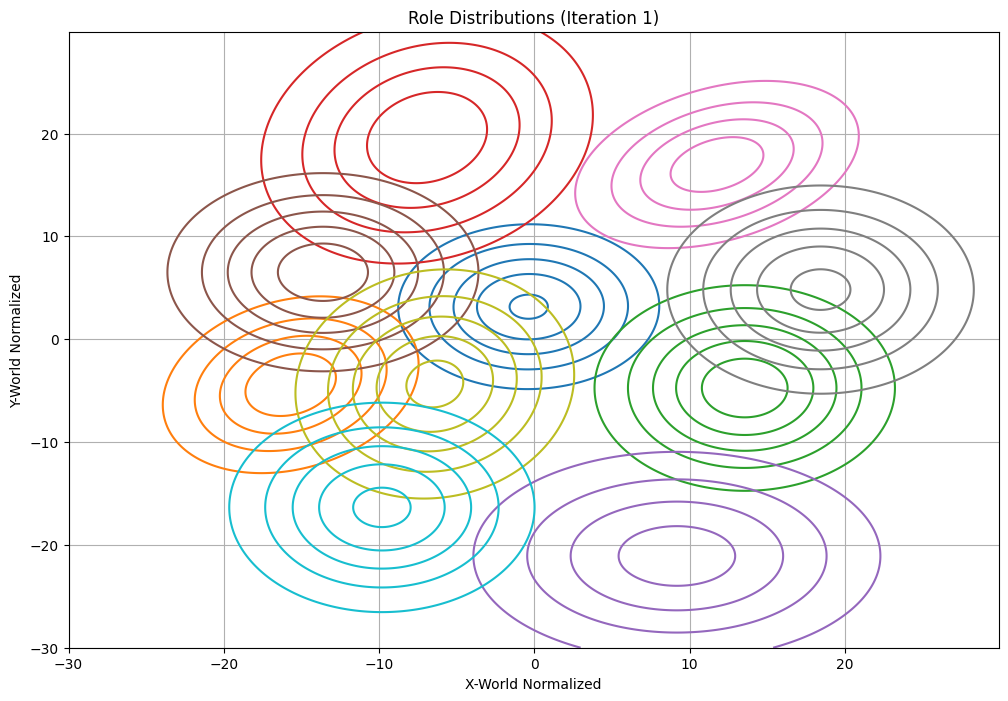

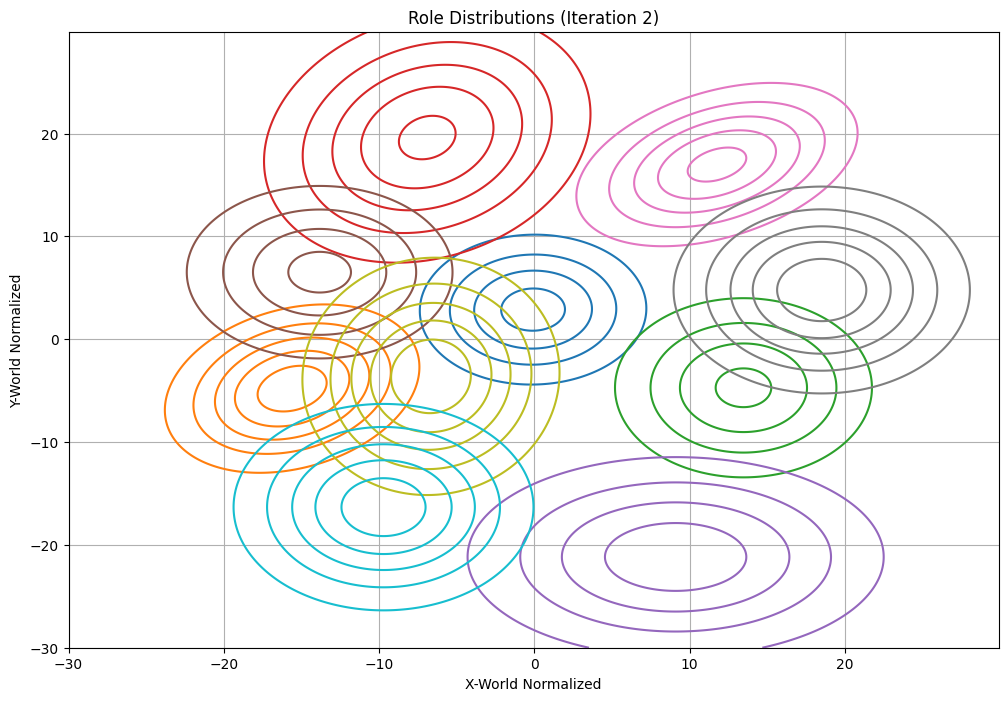

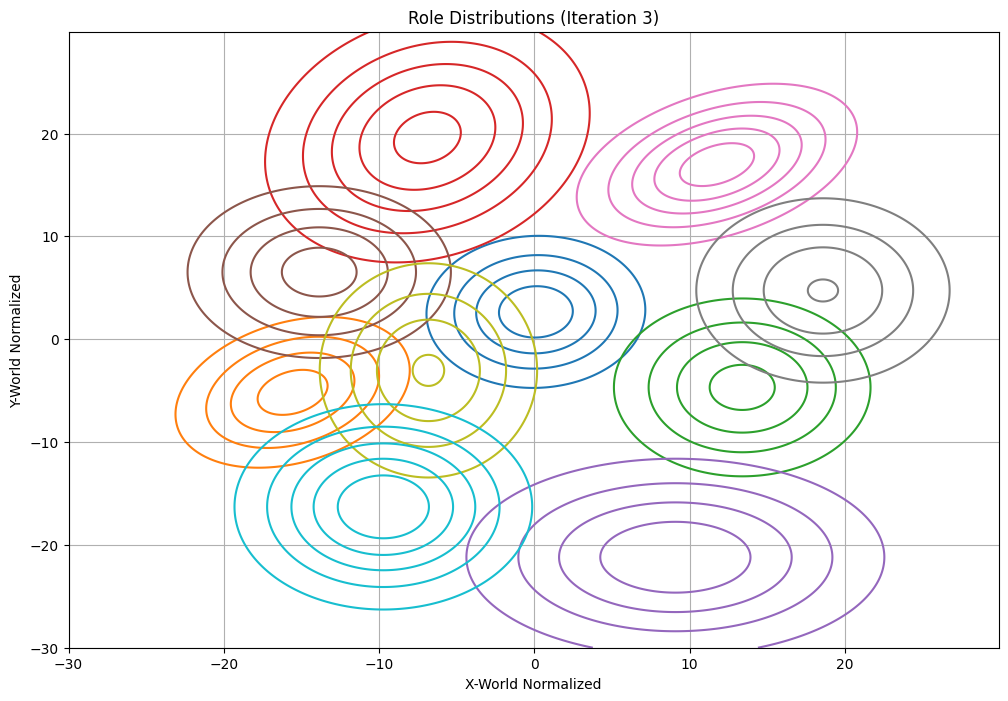

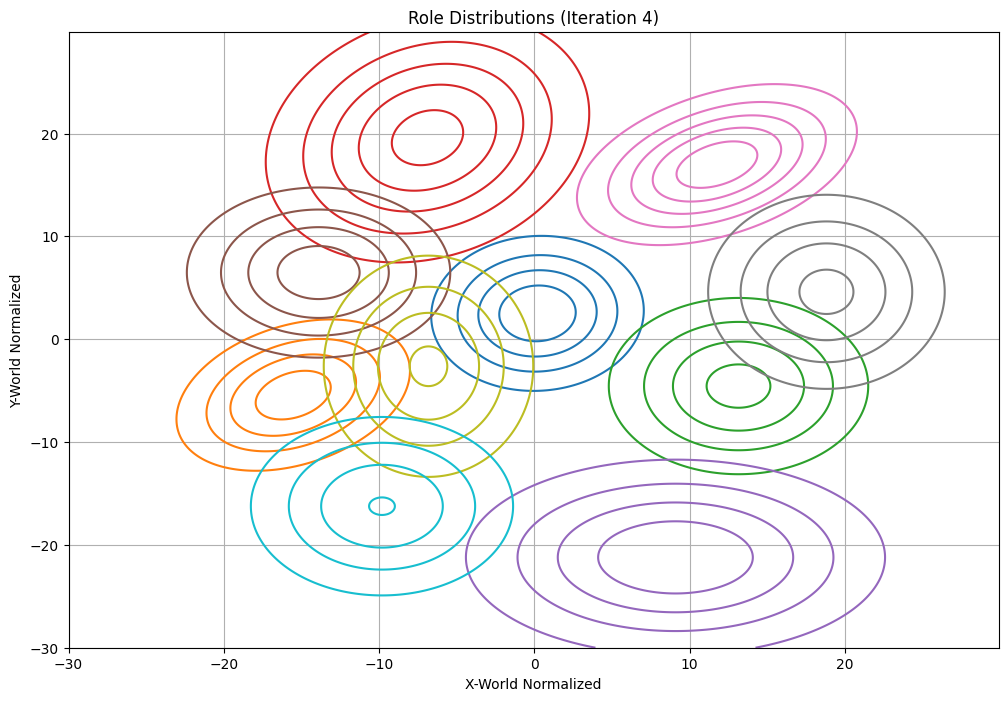

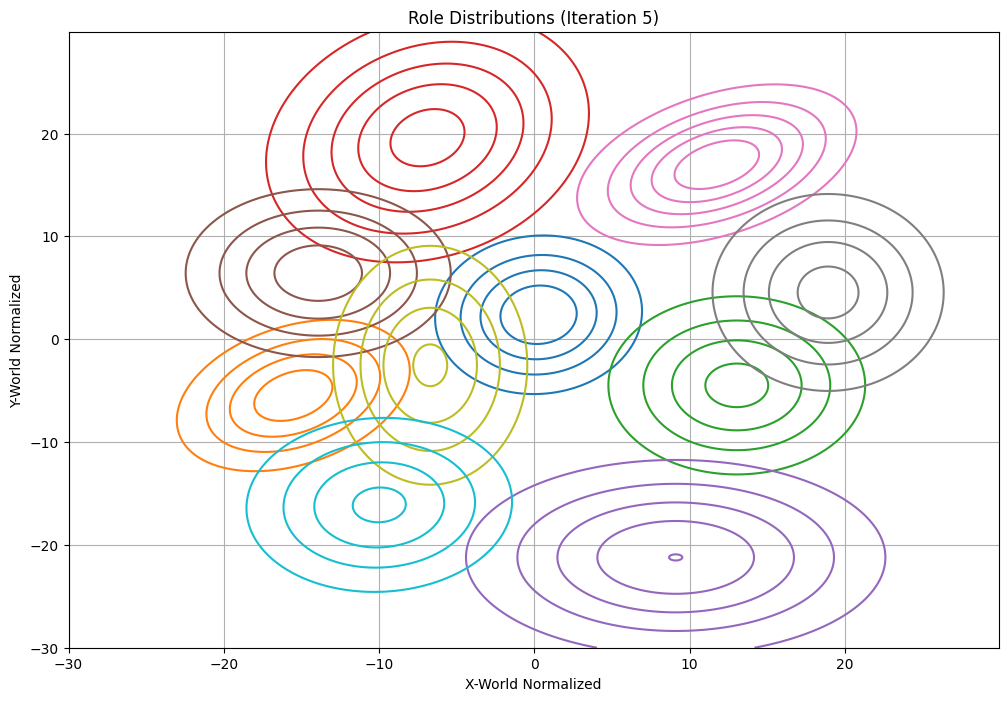

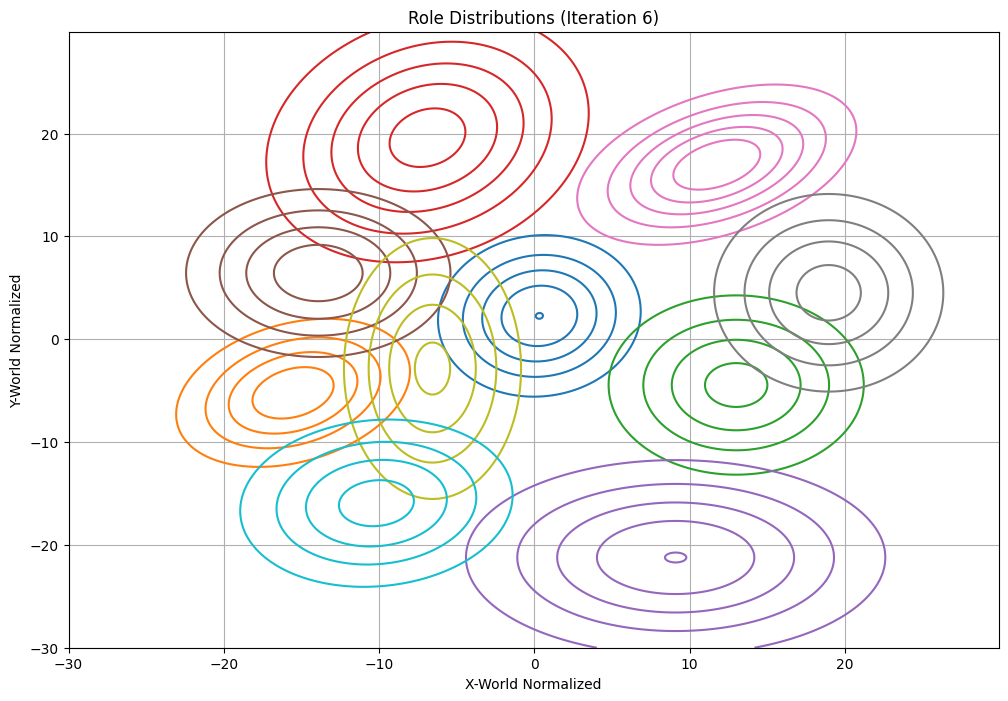

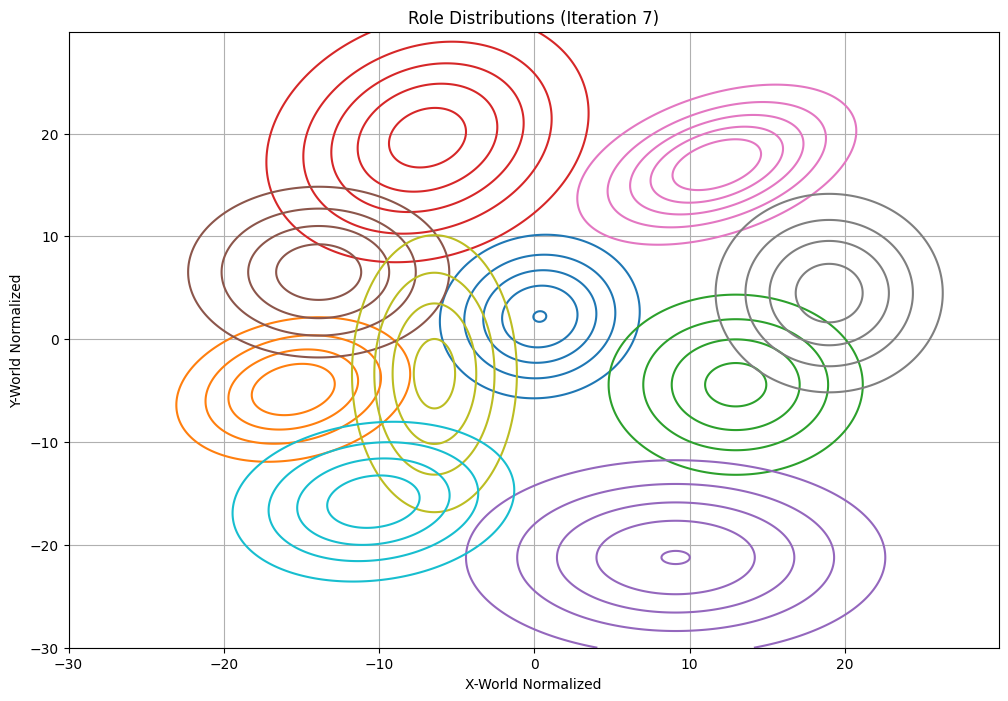

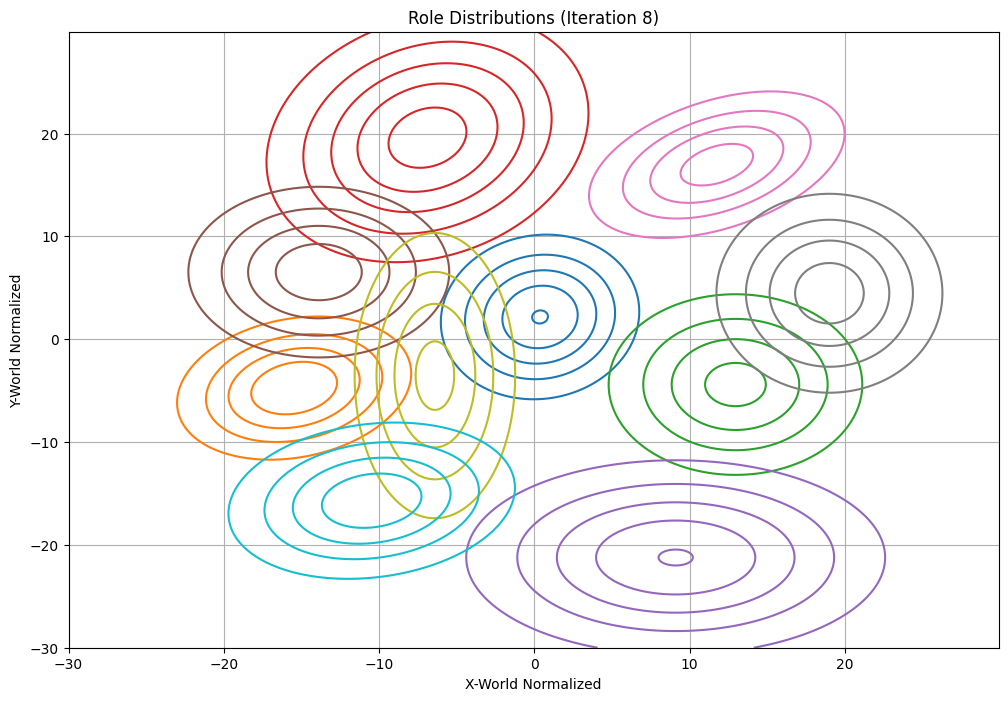

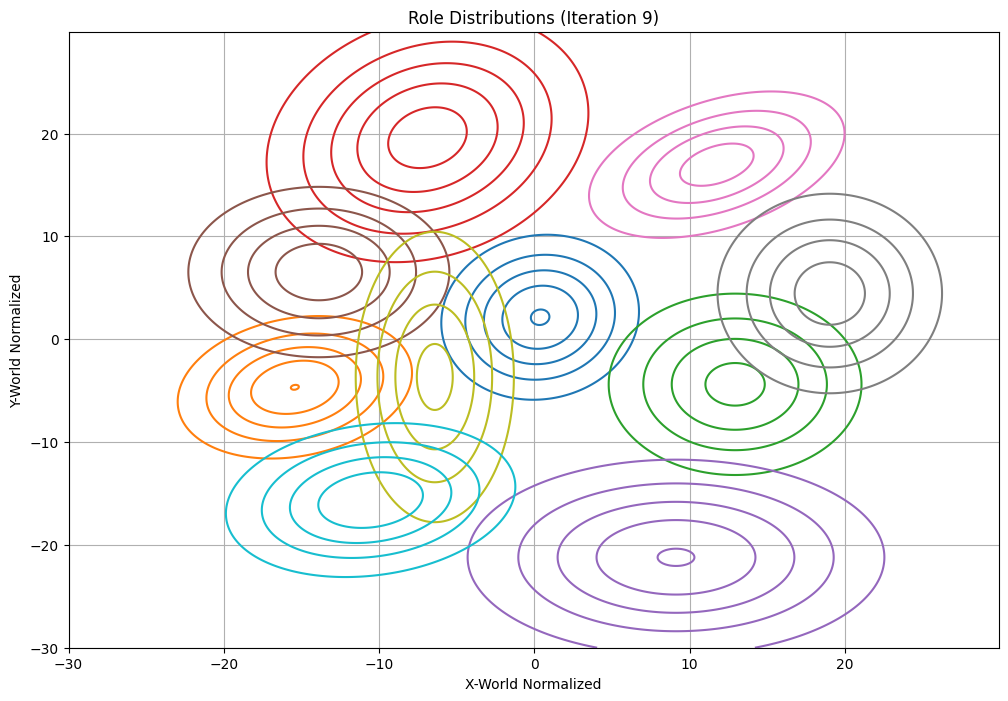

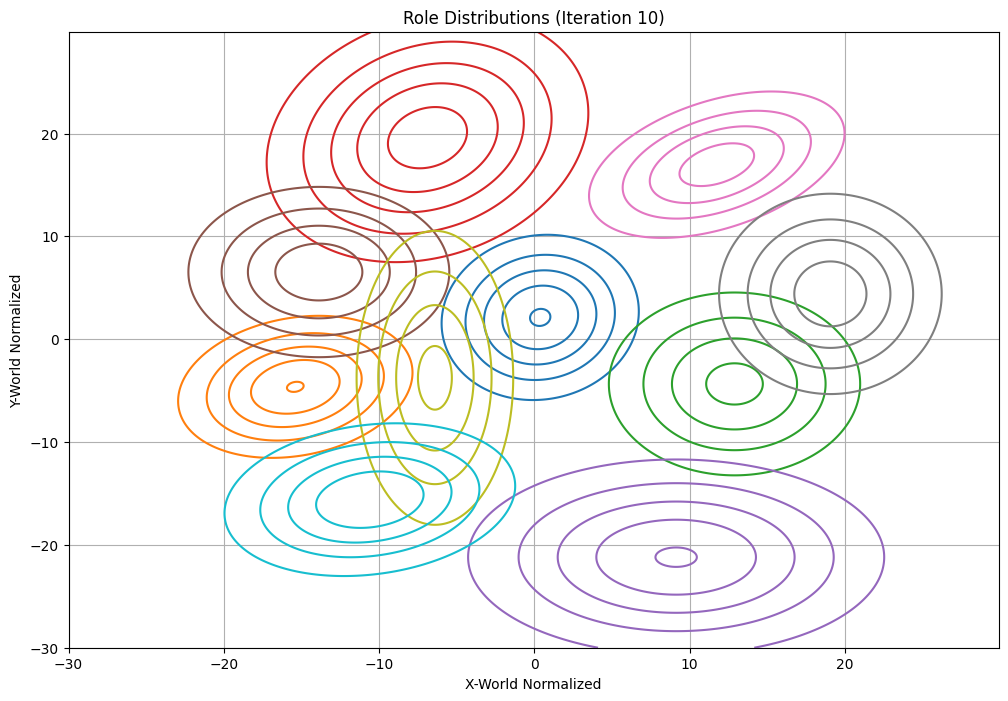

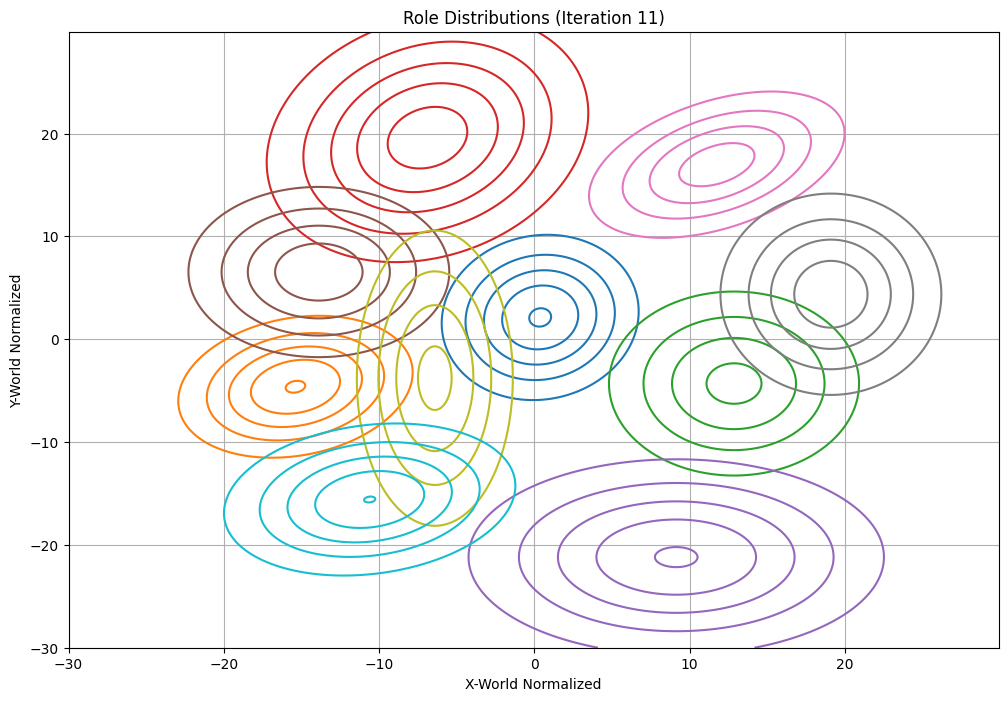

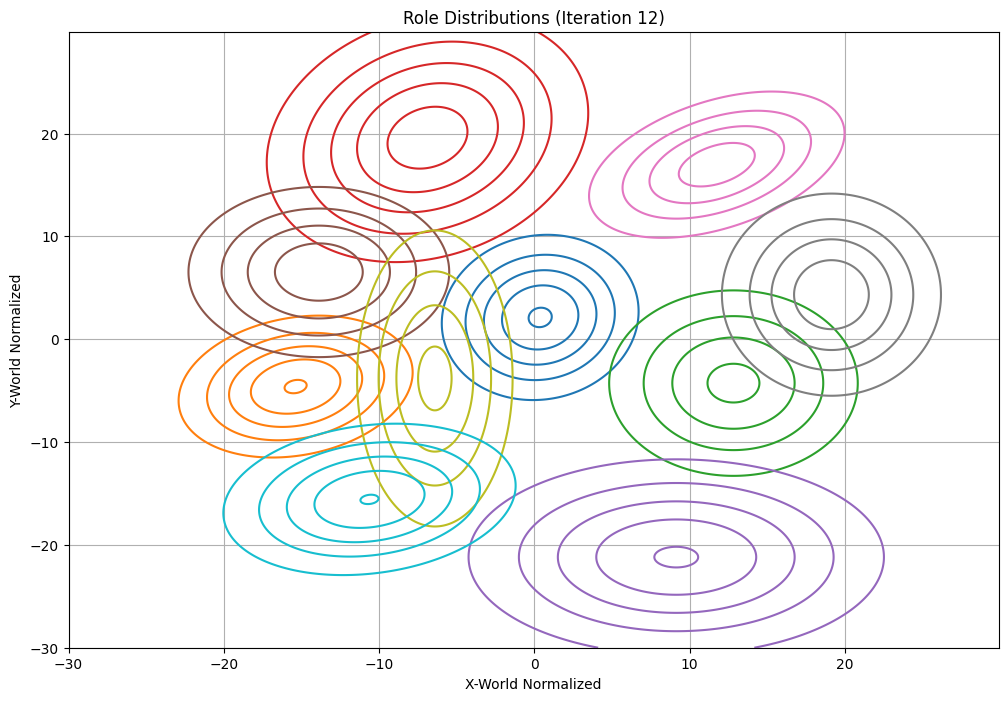

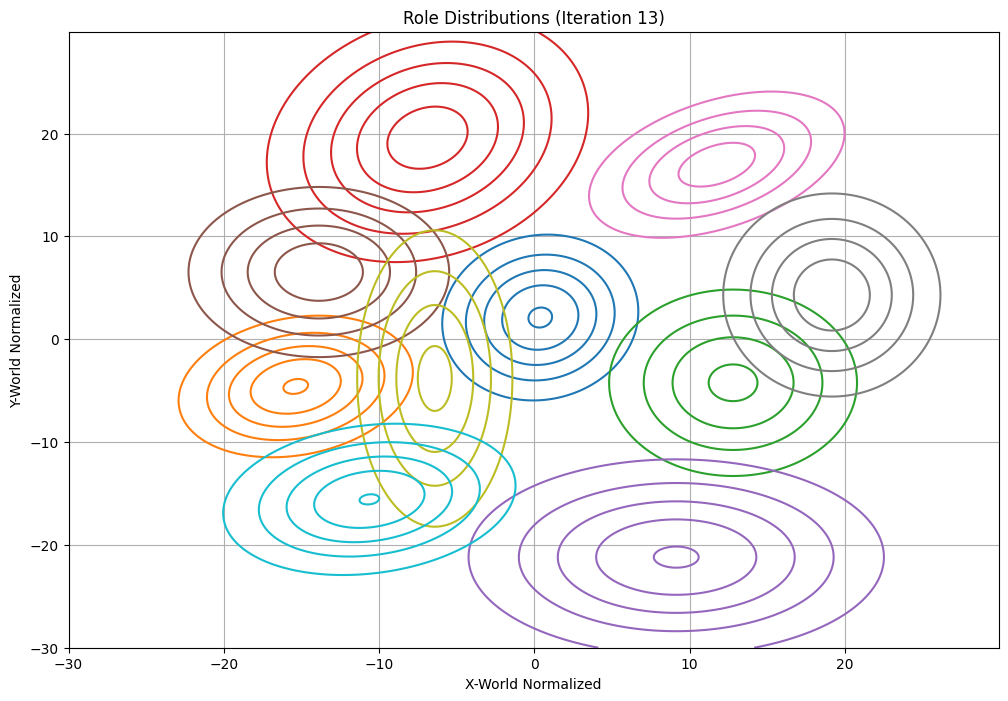

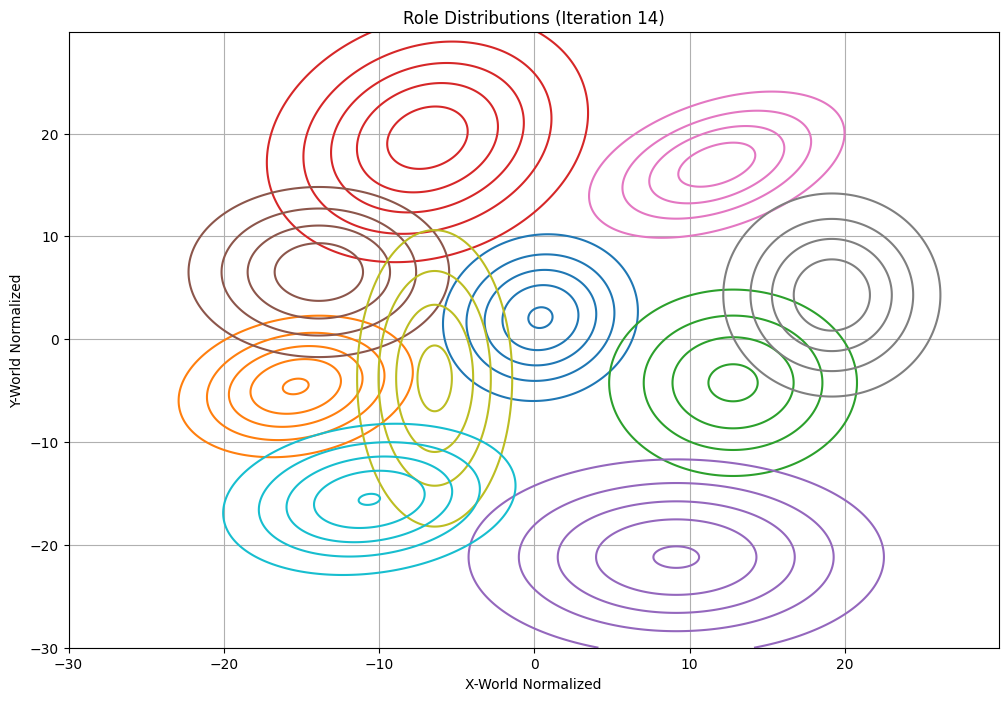

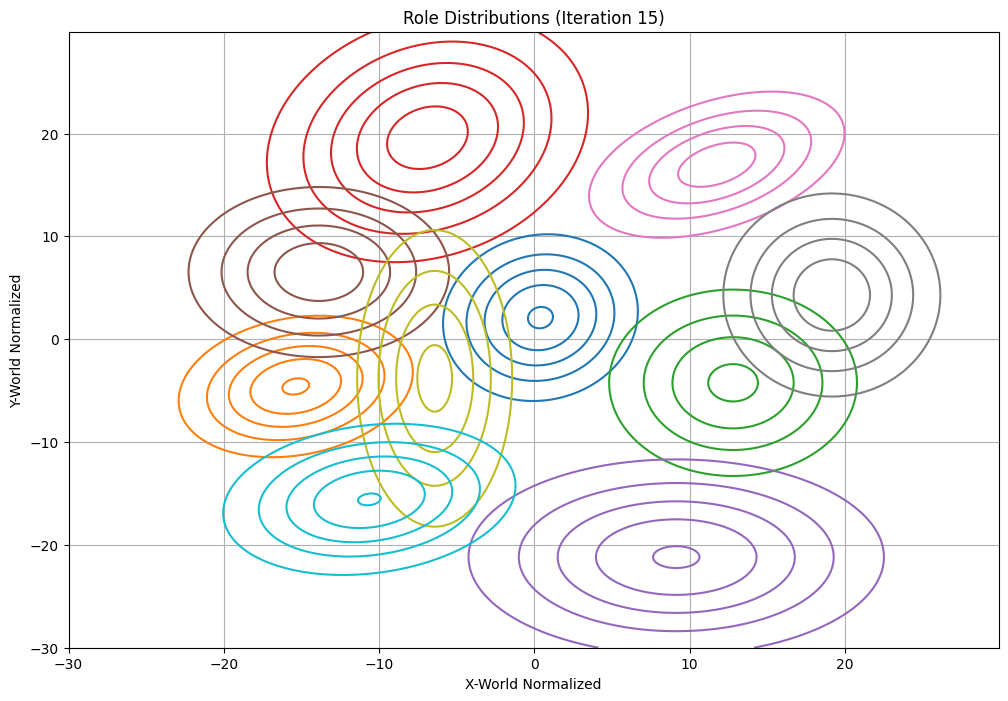

In [ ]:
players_role_0 = normalize_tracking_data(players_role_0)
n_roles = np.unique(players_role_0['track_id'])
n_roles
players_role_0, initial_means = initialize_roles_with_kmeans(players_role_0, n_roles)

# Iteratively assign roles and refine PDFs
players_role_0, role_pdfs = update_roles(players_role_0, initial_means, separation_bias=50.0)

In the next plot, the tracking points which is associated cluster is displayed

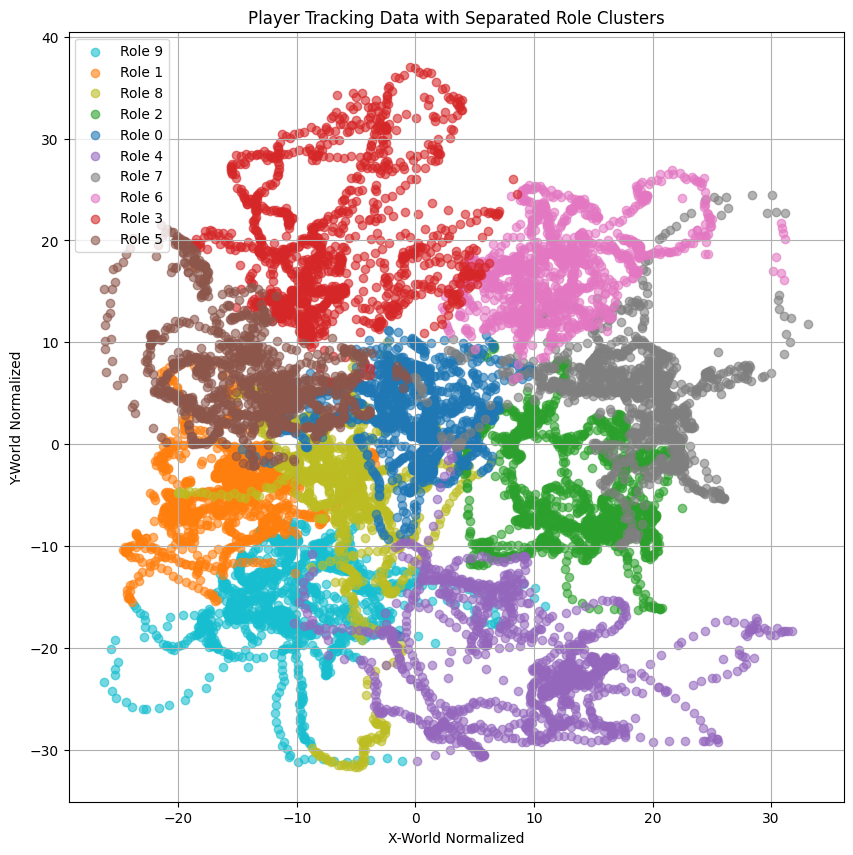

In [ ]:
# Visualize final results

def plot_tracking_data(df):
    fig, ax = plt.subplots(figsize=(10, 10))
    roles = df['specialized_role'].unique()
    colors = [plt.cm.tab10(i % 10) for i in range(len(roles))]
    
    for role in roles:
        role_data = df[df['specialized_role'] == role]
        ax.scatter(role_data['xworld_norm'], role_data['yworld_norm'], label=f'Role {role}', alpha=0.6, color=colors[role_to_index[role]])

    ax.set_title('Player Tracking Data with Separated Role Clusters')
    ax.set_xlabel('X-World Normalized')
    ax.set_ylabel('Y-World Normalized')
    ax.legend()
    ax.grid()
    plt.show()

plot_tracking_data(players_role_0)

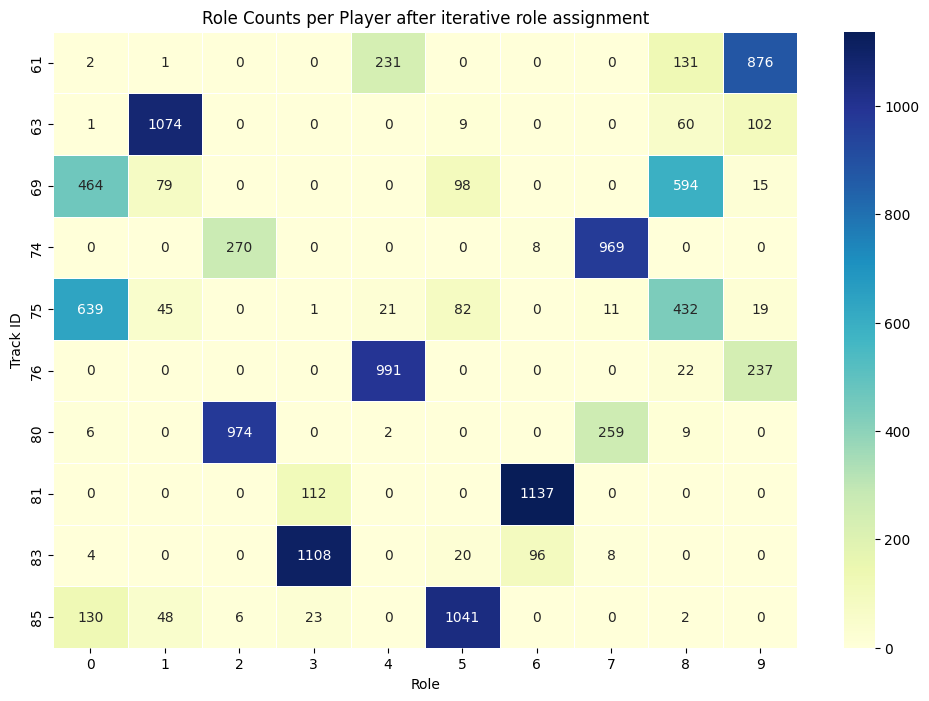

In [ ]:
players_role_0.groupby('track_id')['specialized_role'].unique()
role_counts_per_player = players_role_0.groupby('track_id')['specialized_role'].value_counts()
#print(role_counts_per_player)
role_counts_df = role_counts_per_player.unstack().fillna(0).astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(role_counts_df, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5)
plt.title('Role Counts per Player after iterative role assignment')
plt.xlabel('Role')
plt.ylabel('Track ID')
plt.show()

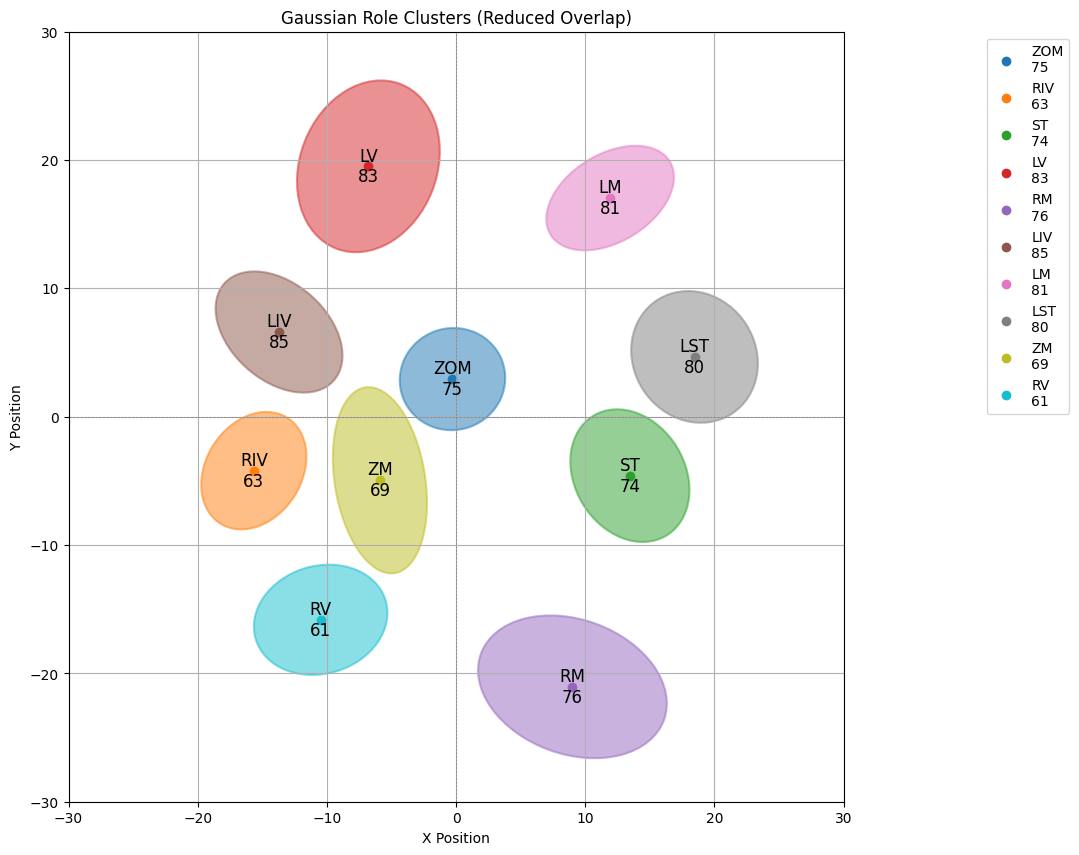

In [ ]:
# Function to plot Gaussian ellipses with transparency
def plot_gaussian_ellipse(mean, cov, ax, label, color, alpha=0.5):
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width, height = 2 * np.sqrt(eigvals)
    ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor=color, alpha=alpha, lw=1.5)
    ax.add_patch(ellipse)
    ax.scatter(mean[0], mean[1], color=color, label=f'{label} ')
    ax.text(mean[0], mean[1], label, color='black', fontsize=12, ha='center', va='center')

# Plot the updated roles
fig, ax = plt.subplots(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(role_pdfs)))
role_to_color_index = {role: idx for idx, role in enumerate(role_pdfs.keys())}

for role, pdf in role_pdfs.items():
    mean = pdf.mean
    cov = pdf.cov
    color_index = role_to_color_index[role] % len(colors)
    role_name = players_role_0[players_role_0['specialized_role'] == role]['role_name'].iloc[0]
    role_track_id = players_role_0[players_role_0['specialized_role'] == role]['track_id'].iloc[0]
    plot_gaussian_ellipse(mean, cov, ax, label=f"{role_name}\n{role_track_id}", color=colors[color_index])

# Formatting plot
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Gaussian Role Clusters (Reduced Overlap)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
plt.grid(True)
plt.show()


look into role switches from player 61

In [ ]:
pl61 = players_role_0[players_role_0["track_id"] == 61]
pl61["specialized_role"].value_counts()

9    876
4    231
8    131
0      2
1      1
Name: specialized_role, dtype: int64

In [ ]:
pl61.shape

(1241, 10)

## get role switch per player(track_id)

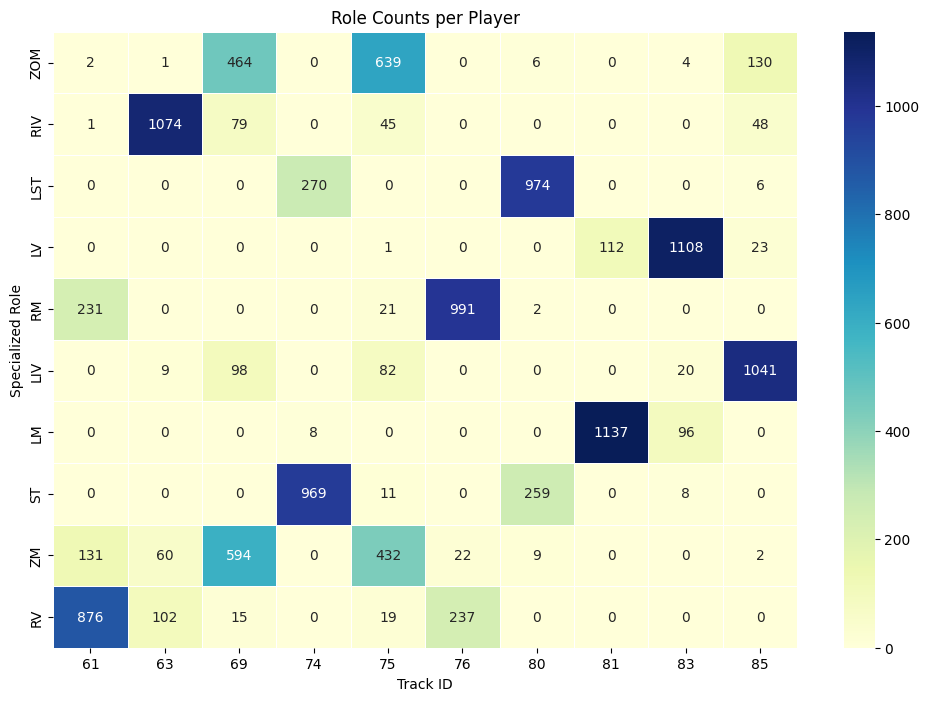

In [ ]:
role_counts_per_player = {}

for track_id in unique_tracks: # unique_tracs from team 0 
    player_data = players_role_0[players_role_0["track_id"] == track_id]
    role_counts = player_data["specialized_role"].value_counts()
    role_counts_per_player[track_id] = role_counts

role_counts_df = pd.DataFrame(role_counts_per_player).fillna(0).astype(int)

# Map specialized_role to role_name
role_name_map = players_role_0.set_index('specialized_role')['role_name'].to_dict()
role_counts_df.index = role_counts_df.index.map(role_name_map)

plt.figure(figsize=(12, 8))
sns.heatmap(role_counts_df, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5)
plt.title('Role Counts per Player')
plt.xlabel('Track ID')
plt.ylabel('Specialized Role')
plt.show()

### the parameters (mean & co-variance) of each role are illustrated:

In [ ]:
for role, pdfs in role_pdfs.items():
    print(f"Role {role} Mean={pdfs.mean}, Covariance={pdfs.cov}")

Role 0 Mean=[-0.27343767  2.93296148], Covariance=[[16.6955085   0.35282535]
 [ 0.35282535 15.87369361]]
Role 1 Mean=[-15.65390983  -4.20186848], Covariance=[[16.61026928  4.4615944 ]
 [ 4.4615944  20.98142158]]
Role 2 Mean=[13.46159733 -4.59137511], Covariance=[[21.26728018 -5.12102798]
 [-5.12102798 26.73816765]]
Role 3 Mean=[-6.7834164  19.51043498], Covariance=[[30.57869732  6.45734884]
 [ 6.45734884 44.82240819]]
Role 4 Mean=[  9.0133842 -21.0469942], Covariance=[[53.42727708 -9.51464338]
 [-9.51464338 30.94981455]]
Role 5 Mean=[-13.70168267   6.60118489], Covariance=[[24.13869511 -8.99119503]
 [-8.99119503 22.30002327]]
Role 6 Mean=[11.93137882 17.03972871], Covariance=[[24.4103733   8.03752329]
 [ 8.03752329 16.60095766]]
Role 7 Mean=[18.46454335  4.66140337], Covariance=[[24.07773118 -2.51528268]
 [-2.51528268 26.36525495]]
Role 8 Mean=[-5.89240267 -4.95193511], Covariance=[[13.2819454  -6.35767555]
 [-6.35767555 52.68629938]]
Role 9 Mean=[-10.47916822 -15.82356285], Covariance

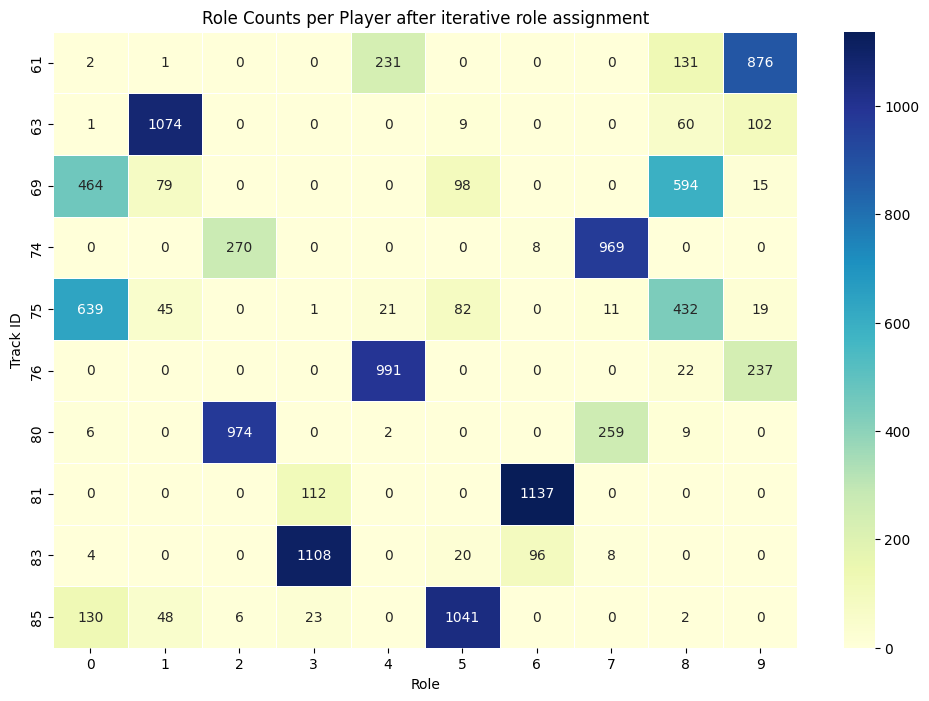

In [ ]:
players_role_0.groupby('track_id')['specialized_role'].unique()
role_counts_per_player = players_role_0.groupby('track_id')['specialized_role'].value_counts()
#print(role_counts_per_player)
role_counts_df = role_counts_per_player.unstack().fillna(0).astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(role_counts_df, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5)
plt.title('Role Counts per Player after iterative role assignment')
plt.xlabel('Role')
plt.ylabel('Track ID')
plt.show()

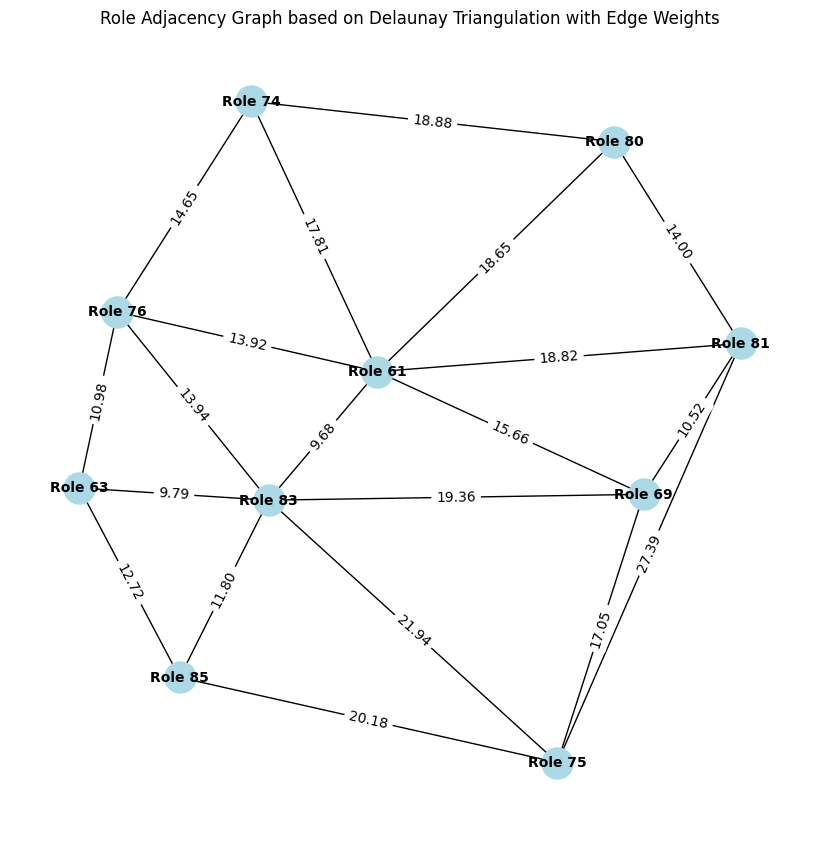

In [ ]:
# mean of each role
role_means = np.array([pdf.mean for pdf in role_pdfs.values()])

# Perform Delaunay triangulation
tri = Delaunay(role_means)

adj_matrix = np.zeros((len(n_roles), len(n_roles)))

# Populate adjacency matrix based on Delaunay simplices
for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            distance = np.linalg.norm(role_means[simplex[i]] - role_means[simplex[j]])
            adj_matrix[simplex[i], simplex[j]] = distance
            adj_matrix[simplex[j], simplex[i]] = distance

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

plt.figure(figsize=(8, 8))
pos = {i: role_means[i] for i in range(len(n_roles))}
labels = {i: role_name_map.get(n_roles[i], f'Role {n_roles[i]}') for i in range(len(n_roles))}
nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d:.2f}' for u, v, d in G.edges(data='weight')})

plt.title('Role Adjacency Graph based on Delaunay Triangulation with Edge Weights')
plt.show()


In [ ]:
adj_matrix

array([[ 0.        ,  0.        , 15.66099702, 17.80989755,  0.        ,
        13.92025958, 18.65364381, 18.81753023,  9.68216721,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        10.97803047,  0.        ,  0.        ,  9.79028202, 12.72170313],
       [15.66099702,  0.        ,  0.        ,  0.        , 17.04623124,
         0.        ,  0.        , 10.51871563, 19.35735828,  0.        ],
       [17.80989755,  0.        ,  0.        ,  0.        ,  0.        ,
        14.64619903, 18.87718065,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 17.04623124,  0.        ,  0.        ,
         0.        ,  0.        , 27.39062092, 21.93703283, 20.18028333],
       [13.92025958, 10.97803047,  0.        , 14.64619903,  0.        ,
         0.        ,  0.        ,  0.        , 13.94487131,  0.        ],
       [18.65364381,  0.        ,  0.        , 18.87718065,  0.        ,
         0.        ,  0.        , 13.99661306

<Axes: >

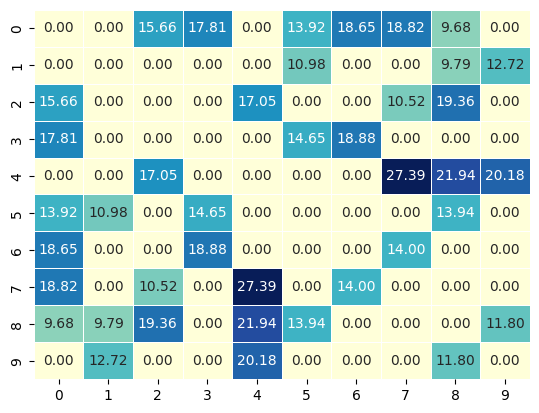

In [ ]:
adj_m = pd.DataFrame(adj_matrix)
sns.heatmap(adj_m, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5)

# All files
The entire dataset consists of 512897 datapoints.

In [ ]:
file_paths = glob.glob('xy_data/*.txt')
tracking_data = pd.concat((pd.read_csv(file, sep=",", header=None) for file in file_paths), ignore_index=True)
tracking_data.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
tracking_data.info

<bound method DataFrame.info of         frame_number  track_id  role    xbox    ybox     w      h  xworld  \
0                  0       144     3   784.3   293.8  30.6   45.3    24.1   
1                  0       145    -1   725.6  1398.3  98.1  110.3    45.2   
2                  0       146     2  1494.2    11.3  17.1   29.7    48.7   
3                  0       147     0  1633.9   216.4  30.4   60.7    54.6   
4                  0       148     2  2542.9   294.3  32.8   43.9    88.7   
...              ...       ...   ...     ...     ...   ...    ...     ...   
512892          7494       659     1  2263.6   183.5  28.6   40.5    87.5   
512893          7494       653     1  2350.7   223.3  26.9   39.9    90.0   
512894          7494       662     0  2278.9   250.6  33.2   52.5    79.8   
512895          7494       655     1  2269.0   226.0  24.2   41.9    82.2   
512896          7494       675     4  2692.0   374.3  36.1   42.3   105.8   

        yworld   IoU  
0         34.2  0.00

In [ ]:
tracking_data.shape

(512897, 10)

In [ ]:
tracking_data["track_id"].nunique()

464

In [ ]:
tracking_data["role"].value_counts()

 1      221990
 0      221469
 2       27990
 4       19862
 3       19752
 155       507
 166       506
 400       361
 396       345
-1         115
Name: role, dtype: int64

At fis2 and stv2 we have unclear roles

In [ ]:
tracking_data[tracking_data["role"] == 400]

frame_number  track_id  role   xbox   ybox      w      h  xworld  \
190022           400       400   400  400.0  400.0  400.0  400.0   400.0   
190042           400       400   400  400.0  400.0  400.0  400.0   400.0   
190062           400       400   400  400.0  400.0  400.0  400.0   400.0   
190084           400       400   400  400.0  400.0  400.0  400.0   400.0   
190105           400       400   400  400.0  400.0  400.0  400.0   400.0   
...              ...       ...   ...    ...    ...    ...    ...     ...   
198121           400       400   400  400.0  400.0  400.0  400.0   400.0   
198144           400       400   400  400.0  400.0  400.0  400.0   400.0   
198166           400       400   400  400.0  400.0  400.0  400.0   400.0   
198188           400       400   400  400.0  400.0  400.0  400.0   400.0   
198211           400       400   400  400.0  400.0  400.0  400.0   400.0   

        yworld    IoU  
190022   400.0  400.0  
190042   400.0  400.0  
190062   400.0  400.0  
190084   400.0  400.0  
190105   400.0  400.0  
...        ...    ...  
198121   400.0  400.0  
198144   400.0  400.0  
198166   400.0  400.0  
198188   400.0  400.0  
198211   400.0  400.0  

[361 rows x 10 columns]